In [ ]:
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

frameFiles = ['S1.jpg', 'S2.jpg', 'S3.jpg', 'S5.jpg', 'S6.jpg']

colorFrames = [cv2.imread(i) for i in frameFiles]
# colorFrames = [cv2.rotate(cv2.imread(i), cv2.cv2.ROTATE_90_CLOCKWISE) for i in frameFiles]
grayFrames = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in colorFrames]


In [ ]:
# cv2_imshow(colorFrames[3])
# print(len(colorFrames))

In [ ]:
orb_detector = cv2.ORB_create(5000)

kps = []
fds = []
for i in grayFrames:
    kp, fd = orb_detector.detectAndCompute(i, None)
    kps.append(kp)
    fds.append(fd)

# for i in kps:
#     print(len(i))
# print(len(kps[1]))
# print(len(fds))

In [ ]:
matchTable = np.zeros((len(fds), len(fds)))
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matchesTable = []

for i in range(len(fds)):
    rmatches = []
    for j in range(i+1, len(fds)):
        matches = matcher.match(fd[i], fd[j])
        matches.sort(key = lambda x: x.distance)
        matchTable[i][j] = matchTable[j][i] = len(matches)*90
        rmatches.append(matches[:len(matches)*90])
    matchesTable.append(rmatches)


In [ ]:
print(matchTable)

[[   0. 1080. 1080. 1260. 1260.]
 [1080.    0. 1440. 1350. 1260.]
 [1080. 1440.    0. 1260. 1080.]
 [1260. 1350. 1260.    0. 1440.]
 [1260. 1260. 1080. 1440.    0.]]


In [ ]:
matchSum = np.zeros((len(fds), 1))
for i in range(len(fds)):
    for j in range(len(fds)):
        matchSum[i] += matchTable[i][j]
print(matchSum)


[[4680.]
 [5130.]
 [4860.]
 [5310.]
 [5040.]]


In [ ]:
def warpTwoImages(img1, img2, H, bpts):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    print("bpts -> ", bpts)
    # bpts = np.float32(bpts).reshape(-1, 1, 2)
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    bpts = np.concatenate((bpts, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    # print(pts)
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    # print(img2)
    # im2_boundary = cv2.warpPerspective([[0,0],[0,h2],[w2,h2],[w2,0]], Ht.dot(H), (xmax-xmin, ymax-ymin))
    # print(im2_boundary)
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result, cv2.perspectiveTransform(bpts, Ht)



In [ ]:
h1,w1 = colorFrames[0].shape[:2]
x = np.array([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
print(x)

[[[  0   0]]

 [[  0 320]]

 [[213 320]]

 [[213   0]]]


In [ ]:
rI = colorFrames[0]
boundaryPts = x
hTimes = []
warpTimes = []
for i in range(1, len(colorFrames)):  
    grI = cv2.cvtColor(rI, cv2.COLOR_BGR2GRAY)
    rIkp, rIfd = orb_detector.detectAndCompute(grI, None)
    matches = matcher.match(rIfd, fds[i])
    matches.sort(key = lambda x: x.distance)
    matches = matches[:int(len(matches)*90)]

    dst_pts = np.float32([rIkp[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    src_pts = np.float32([kps[i][m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    st = time.time()
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    et = time.time()
    hTimes.append(et-st)
    st = time.time()
    rI, boundaryPts = warpTwoImages(rI, colorFrames[i], M, boundaryPts)
    et = time.time()
    warpTimes.append(et-st)
    # boundaryPts.append(pts)

print(hTimes)
print(warpTimes)

bpts ->  [[[  0   0]]

 [[  0 320]]

 [[213 320]]

 [[213   0]]]
bpts ->  [[[0.00000000e+00 2.50000000e+01]]

 [[0.00000000e+00 3.45000000e+02]]

 [[2.13000000e+02 3.45000000e+02]]

 [[2.13000000e+02 2.50000000e+01]]

 [[1.24574333e+02 3.89937534e+01]]

 [[1.04233925e+02 3.33962921e+02]]

 [[3.60652557e+02 4.25730103e+02]]

 [[3.83510406e+02 1.27389908e-01]]]
[0.005545139312744141, 0.05192065238952637]
[0.0038361549377441406, 0.008063316345214844]


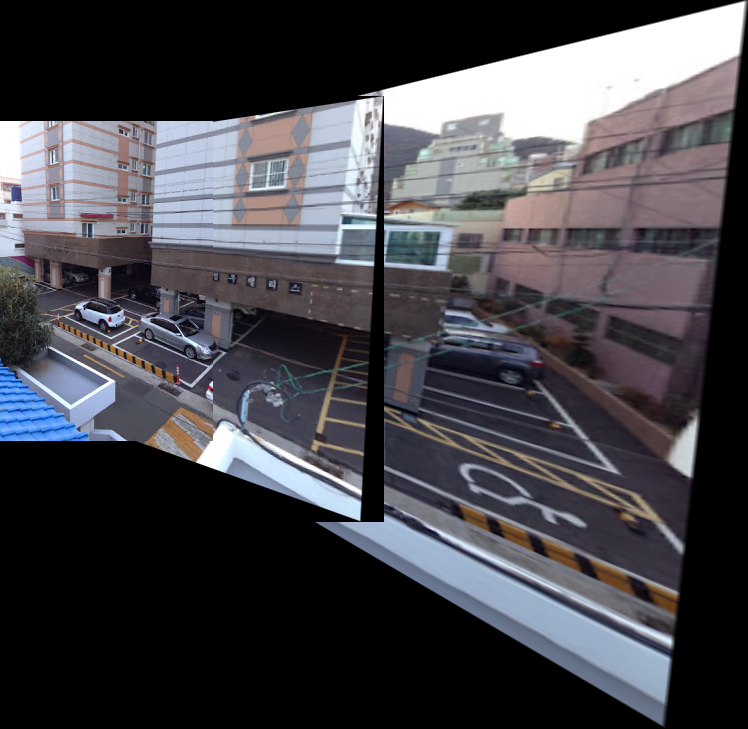

In [ ]:
cv2_imshow(rI)

In [ ]:
print(boundaryPts)
pts = boundaryPts

[[[0.00000000e+00 1.21000000e+02]]

 [[0.00000000e+00 4.41000000e+02]]

 [[2.13000000e+02 4.41000000e+02]]

 [[2.13000000e+02 1.21000000e+02]]

 [[1.24574333e+02 1.34993753e+02]]

 [[1.04233925e+02 4.29962921e+02]]

 [[3.60652557e+02 5.21730103e+02]]

 [[3.83510406e+02 9.61273899e+01]]

 [[2.42052979e+02 1.24199209e+02]]

 [[1.98904129e+02 4.54176758e+02]]

 [[6.65187805e+02 7.28647278e+02]]

 [[7.48496094e+02 4.72152710e-01]]]


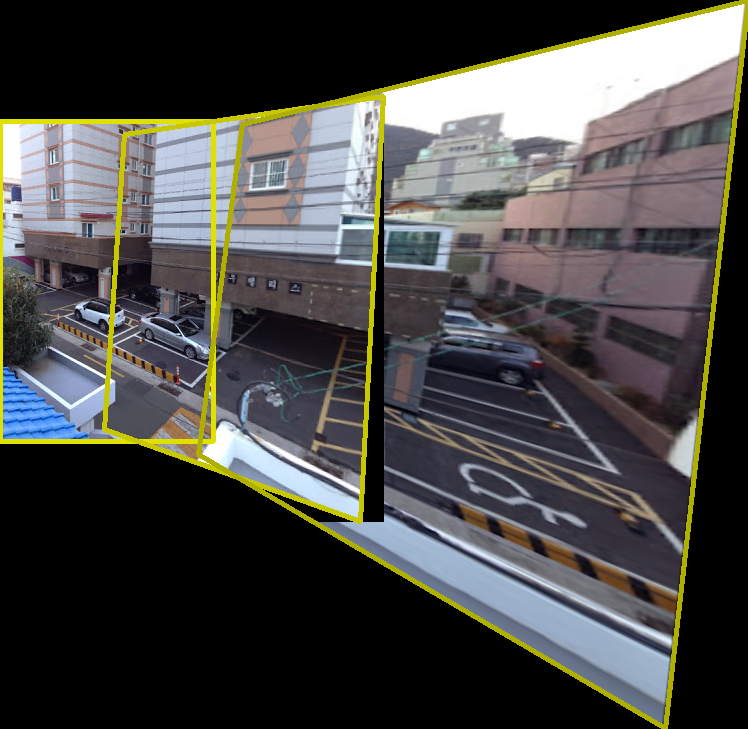

In [ ]:
pts = np.array([[pts[:]]], np.int32)
pts = pts.reshape((-1,1,2))
for i in range(0, len(pts), 4):
    cv2.polylines(rI,[pts[i:i+4]],True,(0,225-25*int(i/4),225-25*int(i/4)),3)  
# img1_color = cv2.resize(img1_color, (1000,650))
# cv2.polylines(rI,[pts[:4]],True,(0,255,255),3)
# cv2.polylines(rI,[pts[4:]],True,(255,255,),3)
cv2_imshow(rI)

In [ ]:
# dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
# src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# result = warpTwoImages(img1_color, img2_color, M)